In [1]:
from models import enc_mtan_classif_activity
import torch
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from NF import MAF, RealNVP

# set model

In [2]:
class multiTimeAttention(nn.Module):
    
    def __init__(self, input_dim, nhidden=16, 
                 embed_time=16, num_heads=1):
        super(multiTimeAttention, self).__init__()
        assert embed_time % num_heads == 0
        self.embed_time = embed_time
        self.embed_time_k = embed_time // num_heads
        self.h = num_heads
        self.dim = input_dim
        self.nhidden = nhidden
        self.linears = nn.ModuleList([nn.Linear(embed_time, embed_time), 
                                      nn.Linear(embed_time, embed_time),
                                      nn.Linear(input_dim*num_heads, nhidden)])
        
    def attention(self, query, key, value, mask=None, dropout=None):
        """
        > The function takes in a query, key, and value, and returns the weighted sum of the values, and the
        attention weights
        
        :param query: the query from the decoder's first attention layer, with shape [batch_size,
        max_length, d_model]
        :param key: the key matrix
        :param value: the input to the attention layer
        :param mask: mask to prevent seeing future words (for decoder)
        :param dropout: The dropout probability
        :return: The attention vector and the attention weights.
        """
        
        "Compute 'Scaled Dot Product Attention'"
        dim = value.size(-1)
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(d_k)
        scores = scores.unsqueeze(-1).repeat_interleave(dim, dim=-1)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-3) == 0, -1e9)
        p_attn = F.softmax(scores, dim = -2)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.sum(p_attn*value.unsqueeze(-3), -2), p_attn
    
    
    def forward(self, query, key, value, mask=None, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        batch, seq_len, dim = value.size()
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        value = value.unsqueeze(1)
        query, key = [l(x).view(x.size(0), -1, self.h, self.embed_time_k).transpose(1, 2)
                      for l, x in zip(self.linears, (query, key))]
        x, _ = self.attention(query, key, value, mask, dropout)
        x = x.transpose(1, 2).contiguous() \
             .view(batch, -1, self.h * dim)
        return self.linears[-1](x)

In [18]:

class enc_mtan_classif_activity(nn.Module):
 
    def __init__(self, input_dim, nhidden=16, 
                 embed_time=16, num_heads=1, learn_emb=True, freq=10., device='cuda'):
        super(enc_mtan_classif_activity, self).__init__()
        assert embed_time % num_heads == 0
        self.freq = freq
        self.embed_time = embed_time
        self.learn_emb = learn_emb
        self.dim = input_dim
        self.device = device
        self.nhidden = nhidden
        self.att = multiTimeAttention(2*input_dim, nhidden, embed_time, num_heads)
        # self.gru = nn.GRU(nhidden, nhidden, batch_first=True)
        # self.linear = nn.Linear(nhidden, self.dim * 2)
        
        # n_blocks 1, 
        # input_size 1, 
        # hidden_size 32, 
        # n_hidden 1, 
        # cond_label_size=32, 
        # batch_norm=False
        self.nf = MAF(n_blocks = 1, input_size = 1, hidden_size = 64, n_hidden = 1, cond_label_size=4, batch_norm=False,activation='tanh')
        
    def time_embedding(self, pos, d_model):
        pe = torch.zeros(pos.shape[0], pos.shape[1], d_model)
        position = 48.*pos.unsqueeze(2)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(np.log(self.freq) / d_model))
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return pe
    
       
    def forward(self, x, time_steps):
        batch = x.size(0)
        time_steps = time_steps.cpu()
        mask = x[:, :, self.dim:]
        mask = torch.cat((mask, mask), 2)
        if self.learn_emb:
            key = self.learn_time_embedding(time_steps).to(self.device)
        else:
            key = self.time_embedding(time_steps, self.embed_time).to(self.device)
        
        out = self.att(key, key, x, mask)
        # out = out[:,:,:self.dim]
        # _, out = self.gru(out)
        data = x[:,:,:self.dim]
        out = out.reshape([-1,4])
        data = data.reshape([-1,1])
        print(self.dim, out.shape, data.shape, sep='\n')
        log_prob = self.nf.log_prob(data,out).reshape([batch,-1])
        log_prob = log_prob.reshape([batch,-1,self.dim])
        log_prob = log_prob.mean(dim=1)
        # print(log_prob.shape)
        return log_prob

In [19]:
model = enc_mtan_classif_activity(
    input_dim=45,
    nhidden=4 * 45,
    embed_time=128,
    num_heads=1,
    learn_emb=False,
    freq=10,
    device='cpu'
)

In [20]:
print(model)

enc_mtan_classif_activity(
  (att): multiTimeAttention(
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=90, out_features=180, bias=True)
    )
  )
  (nf): MAF(
    (net): FlowSequential(
      (0): MADE(
        (net_input): MaskedLinear(in_features=1, out_features=64, bias=True, cond_features=4)
        (net): Sequential(
          (0): Tanh()
          (1): MaskedLinear(in_features=64, out_features=64, bias=True)
          (2): Tanh()
          (3): MaskedLinear(in_features=64, out_features=2, bias=True)
        )
      )
    )
  )
)


# Data Process

In [6]:
import sys
sys.path.append('/root/zengzihui/ISST/ISST_Baselines/mTAN/src/get_SWaT')
from get_SWaT import get_swat_data

In [7]:
data_obj = get_swat_data(batch_size = 128)

> less = 1.0 Using 1.0 FULL DATA !

Beta = 1
Train Path: /root/zengzihui/ISST/ISST_Baselines/mTAN/src/get_SWaT/raw_dataset/train.csv
Test Path : /root/zengzihui/ISST/ISST_Baselines/mTAN/src/get_SWaT/raw_dataset/test.csv


In [8]:
train_loader = data_obj["train_dataloader"]
test_loader = data_obj["test_dataloader"]
val_loader = data_obj["val_dataloader"]
dim = data_obj["input_dim"]

In [9]:
data, label  = train_loader.dataset.__getitem__(0)[0], train_loader.dataset.__getitem__(0)[1]

In [10]:
data = data.unsqueeze(0)
label  = label.unsqueeze(0)

In [11]:
observed_data, observed_mask, observed_tp = data[:, :, :dim], data[:, :, dim:2*dim], data[:, :, -1]

In [12]:
observed_mask

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [21]:
log = model(torch.cat((observed_data, observed_mask), 2), observed_tp)

45
torch.Size([2700, 4])
torch.Size([2700, 1])
torch.Size([1, 45])


In [38]:
log.mean()

tensor(-10.4520, grad_fn=<MeanBackward0>)

In [ ]:
model.att

# Debug model.att

In [ ]:
observed_tp

In [ ]:
key = model.time_embedding(observed_tp, 128)
key

In [ ]:
# out = model.att(key, key, x, mask)
out = model.att(key, key, 
            torch.cat((observed_data, observed_mask), 2),
            torch.cat((observed_mask, observed_mask), 2))

In [ ]:
query = key;
key = key;
value = torch.cat((observed_data, observed_mask), 2);
mask = torch.cat((observed_mask, observed_mask), 2);

rst_sum, p_attn = attention(query, key, value, mask)

# Debug ROC eval scores

In [7]:
import pandas as pd


df = pd.read_csv("/root/zengzihui/ISST/ISST_Baselines/mTAN/src/label_test.csv", index_col=0)

In [8]:
label = df.iloc[:, 0].to_list()
predict = df.iloc[:,1].to_list()

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [10]:
roc_auc_score(label, predict)

0.8554982604390202

In [11]:

def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

In [14]:
df = df.rename({'0':"label", '1':"pred"}, axis = 1)

In [16]:
df.pred.describe()

thresh = df.pred.quantile(0.75)

In [17]:
thresh

-1.5909915566444397

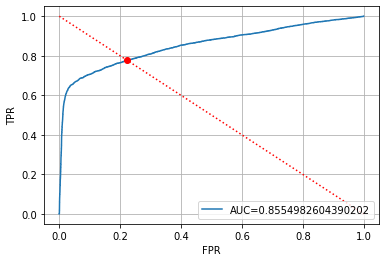

In [22]:
thresh = ROC(label, predict)

In [18]:
predict_ = [0 if x < thresh else 1 for x in predict]

In [19]:
confusion_matrix(label, predict_)

array([[32324,  7097],
       [ 1339,  4124]])

In [20]:
f1, pre, rec = f1_score(label, predict_), precision_score(label, predict_), recall_score(label, predict_)


print(f1, pre, rec)

0.49436585950611356 0.3675251760092683 0.7548965769723595


In [21]:
print(classification_report(label, predict_))

              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88     39421
         1.0       0.37      0.75      0.49      5463

    accuracy                           0.81     44884
   macro avg       0.66      0.79      0.69     44884
weighted avg       0.89      0.81      0.84     44884



# Debug Scores

In [2]:
import pandas as pd


df = pd.read_csv("/root/zengzihui/ISST/ISST_Baselines/mTAN/src/label_test_beta_0.3.csv", index_col=0)

In [3]:
df = df.rename({'0':"label", '1':"pred"}, axis = 1)

In [4]:
df

,label,pred
0,0.0,-2.675318
1,0.0,-2.706148
2,0.0,-2.723125
3,0.0,-2.756900
4,0.0,-2.774264
...,...,...
44879,0.0,-1.806740
44880,0.0,-1.904922
44881,0.0,-1.877951
44882,0.0,-1.951714


In [5]:
df.label = df.label.astype(int)
df.label = df.label.map({0 : '0', 1:'1'})
df.label

0        0
1        0
2        0
3        0
4        0
        ..
44879    0
44880    0
44881    0
44882    0
44883    0
Name: label, Length: 44884, dtype: object

# Search

In [52]:
def search_best_f1(label, predict):
    f1_best = 0

    f1_list = []
    pre_list = []
    rec_list = []
    thr_list = []

    thresh_holds = set([round(x, 1) for x in predict])
    for thr in thresh_holds:
        predict_ = [0 if x < thr else 1 for x in predict]
        f1, pre, rec = f1_score(label, predict_), precision_score(label, predict_), recall_score(label, predict_)

        if f1 > f1_best:
            
            f1_best = f1;
            f1_list.append(f1)
            pre_list.append(pre)
            rec_list.append(rec)
            thr_list.append(thr)
            print(f"Best Threshold: {thr}")
            print("[f1 = {%.4f}, pre = {%.4f}, rec = {%.4f}]" % (f1, pre, rec))

    

    return f1_best, f1_list, pre_list, rec_list

In [53]:
# beta = 1.0
df = pd.read_csv("/root/zengzihui/ISST/ISST_Baselines/mTAN/src/label_test.csv", index_col=0)
df = df.rename({'0':"label", '1':"pred"}, axis = 1)
label = df.iloc[:, 0].to_list()
predict = df.iloc[:,1].to_list()

_, _, _, _ = search_best_f1(label, predict)

Best Threshold: -0.8
[f1 = {0.5070}, pre = {0.8726}, rec = {0.3573}]
Best Threshold: -1.1
[f1 = {0.6614}, pre = {0.8447}, rec = {0.5435}]
Best Threshold: -1.2
[f1 = {0.6791}, pre = {0.8177}, rec = {0.5806}]
Best Threshold: -1.3
[f1 = {0.6869}, pre = {0.7840}, rec = {0.6112}]


In [54]:
# beta = 0.3
df = pd.read_csv("/root/zengzihui/ISST/ISST_Baselines/mTAN/src/label_test_beta_0.3.csv", index_col=0)
df = df.rename({'0':"label", '1':"pred"}, axis = 1)
label = df.iloc[:, 0].to_list()
predict = df.iloc[:,1].to_list()

_, _, _, _ = search_best_f1(label, predict)

Best Threshold: -0.8
[f1 = {0.7405}, pre = {0.8896}, rec = {0.6343}]
Best Threshold: -0.7
[f1 = {0.7431}, pre = {0.9005}, rec = {0.6326}]
Best Threshold: -0.5
[f1 = {0.7474}, pre = {0.9268}, rec = {0.6262}]
Best Threshold: -0.3
[f1 = {0.7522}, pre = {0.9583}, rec = {0.6191}]
